In [96]:
import os
import cv2
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
import tensorflow_hub as hub
import json
import matplotlib.image as mpimg
from skimage.transform import resize
from moviepy.editor import VideoFileClip

from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

# Convert video into frames

In [128]:
# convert video into frames

# !video-toimg output_1.avi

output_folder = "output_1/"
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

!ffmpeg -i output_1.avi -vf fps=30 output_1/%04d.png

ffmpeg version 6.1.1 Copyright (c) 2000-2023 the FFmpeg developers
  built with Apple clang version 15.0.0 (clang-1500.1.0.2.5)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/6.1.1_3 --enable-shared --enable-pthreads --enable-version3 --cc=clang --host-cflags= --host-ldflags='-Wl,-ld_classic' --enable-ffplay --enable-gnutls --enable-gpl --enable-libaom --enable-libaribb24 --enable-libbluray --enable-libdav1d --enable-libharfbuzz --enable-libjxl --enable-libmp3lame --enable-libopus --enable-librav1e --enable-librist --enable-librubberband --enable-libsnappy --enable-libsrt --enable-libssh --enable-libsvtav1 --enable-libtesseract --enable-libtheora --enable-libvidstab --enable-libvmaf --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lzma --enable-libfontconfig --enable-libfreetype --enable-frei0r --enable-libass --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-libopenvin

In [129]:
DIRNAME = "output_1"
# IMG_SIZE = [448, 448]
IMG_SIZE = [896, 896]
video_path = "output_1.avi"
fps=30

# Image Loader

In [133]:
# Load all images into a list

test_images = []
test_images_size_tups = []

for file in os.listdir(DIRNAME):
    img = cv2.imread(f"{DIRNAME}/{file}")
    test_images_size_tups.append(img.shape)

    img = cv2.resize(img, IMG_SIZE)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    test_images.append(img)

In [100]:
# # get video length and frame rate 

# def get_video_length(video_path):
#     clip = VideoFileClip(video_path)
#     duration = clip.duration
#     clip.close()
#     return duration

# video_length = get_video_length(video_path)
# # print("Length of the video is:", video_length, "seconds")

# frame_rate = len(test_images) / video_length



In [135]:
def frame_index_to_time_stamp(frame_index, frame_rate):
    return frame_index / frame_rate

# Image Annotation with detection

In [102]:
# Annotate the images with detected boxes

# Choose threshold carefully: larger the threshold => more coarse/ fewer boxes

def get_annotated_img_objects(img, boxes, scores, num_detections, score_threshold=0.2):
    image = np.array(img)
    objects = 0
    box_list = []

    for i in range(num_detections):
        if scores[i] >= score_threshold:
            box = boxes[i]
            y_min, x_min, y_max, x_max = box
            
            cv2.rectangle(image, (int(x_min), int(y_min)), (int(x_max), int(y_max)), (0, 255, 0), 2)

            # print coordinates of the boxes
            # print((int(x_min),int(y_min)),(int(x_max), int(y_max)))

            box_list.append((int(x_min), int(y_min), int(x_max), int(y_max)))
            objects += 1

    return image, objects, box_list

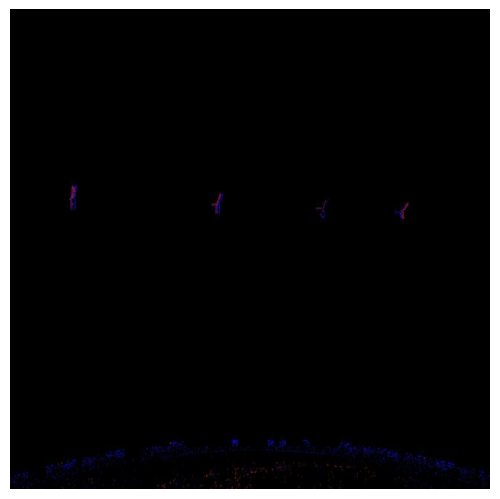

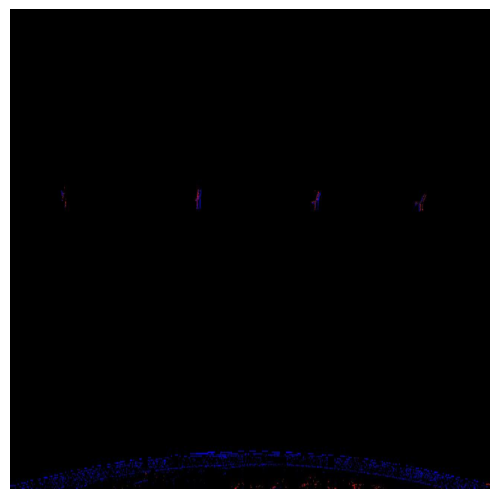

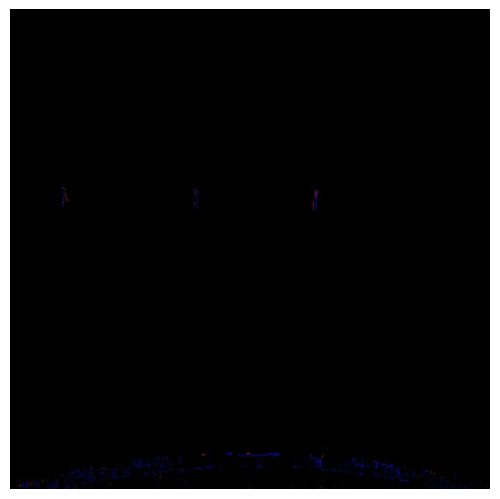

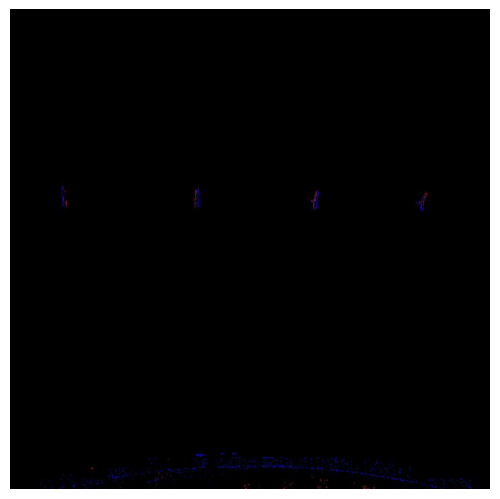

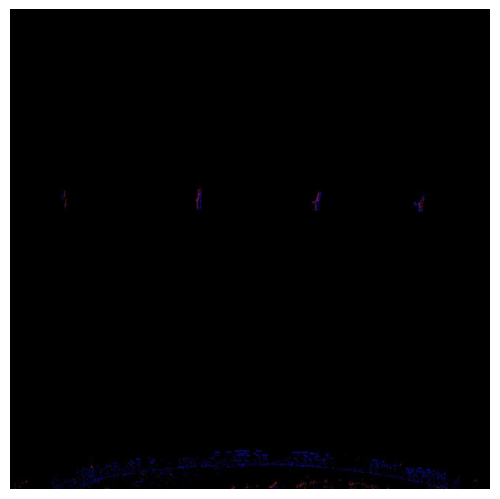

In [103]:
# Test image

test_images_size_tups[:5], test_images[0].shape, test_images[0].max()

for img in test_images[:5]:
    plt.imshow(img)
    plt.axis('off')
    plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
    plt.show()

# Test with different methods

## Using effcientdet lite2-detector

In [104]:
effdet2_model = hub.KerasLayer("https://kaggle.com/models/tensorflow/efficientdet/frameworks/tensorflow2/variations/lite2-detection/versions/1")

Image index: 25
Time stamp : 0.87 s No. of objects: 4
Detection Coordinates: [(149, 327, 175, 385), (406, 347, 437, 395), (672, 373, 697, 407), (562, 369, 587, 405)]


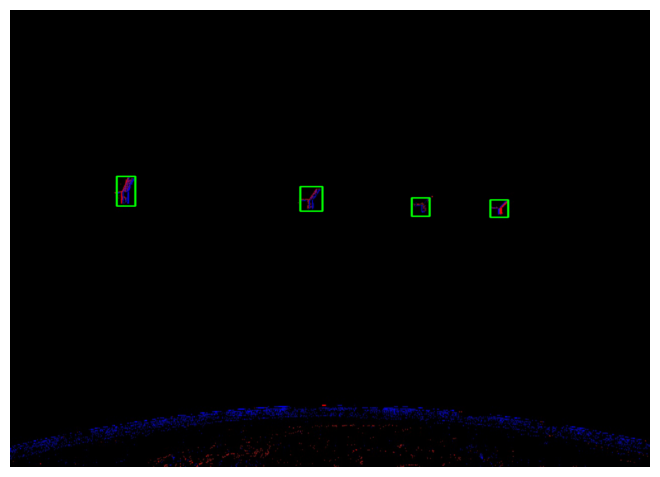

In [142]:
# Test image

# index = random.randint(0, len(test_images) - 1)
index = 25
print("Image index:", index)

sample_image_t = tf.constant(test_images[index], dtype=tf.uint8)
sample_image_t = tf.expand_dims(sample_image_t, axis=0)
image_np = sample_image_t.numpy()

boxes, scores, classes, num_detections = effdet2_model(image_np)

image_np = image_np[0]

# print("Image shape:", image_np.shape)
# print("Model Result Shapes:", boxes.shape, scores.shape, classes.shape, num_detections)
# print ("Detection Coordinates:")

img, objects, box_list = get_annotated_img_objects(image_np, boxes[0], scores[0], num_detections[0])


# print("No. of objects:", objects)
# print ("Detection Coordinates:")
# print (box_list)

img, objects, box_list = get_annotated_img_objects(image_np, boxes[0], scores[0], num_detections[0])
time_stamp = frame_index_to_time_stamp(index+1, fps)

print("Time stamp :", round(time_stamp,2), "s","No. of objects:", objects)
# print("No. of objects:", objects)
print ("Detection Coordinates:", box_list)


# print (box_list)

# # Specify the output file path
# output_file_path = "coordinates.txt"

# # Write the list to the text file
# with open(output_file_path, "w") as output_file:
#     output_file.write(f"Image Index {index}:\n")
#     for values in box_list:
#         output_file.write(f"{values}\n")
#     output_file.write(f"No. of objects: {objects}\n")


# Reshape the image to the desired dimensions
# Specify the new dimensions
new_width = 1400
new_height = 1000
img = resize(img, (new_height, new_width))


# print("No. of objects:", objects)
plt.imshow(img)
plt.axis('off')
plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
plt.show()

# # Create a directory to save the plots if it doesn't exist
# output_folder = "results/"
# if not os.path.exists(output_folder):
#     os.makedirs(output_folder)

# plt.savefig(output_folder + str(index) + '_effdet2_result.png')


## Using effcientdet lite3-detector

In [106]:
effdet3_model = hub.KerasLayer("https://kaggle.com/models/tensorflow/efficientdet/frameworks/tensorflow2/variations/lite3-detection/versions/1")

Image index: 30
No. of objects: 6
Detection Coordinates:
[(569, 342, 589, 380), (743, 353, 765, 385), (95, 327, 110, 372), (357, 340, 372, 378), (429, 875, 447, 893), (354, 882, 376, 894)]


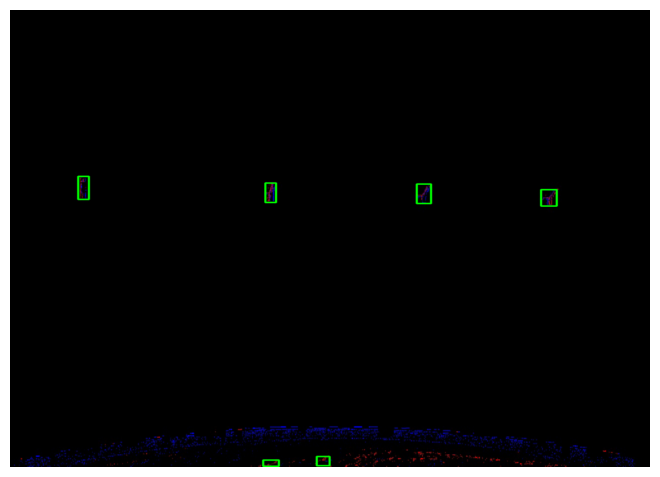

In [141]:
# Test image

# index = random.randint(0, len(test_images) - 1)
index = 30
print("Image index:", index)

sample_image_t = tf.constant(test_images[index], dtype=tf.uint8)
sample_image_t = tf.expand_dims(sample_image_t, axis=0)
image_np = sample_image_t.numpy()

boxes, scores, classes, num_detections = effdet3_model(image_np)

image_np = image_np[0]

# print("Image shape:", image_np.shape)
# print("Model Result Shapes:", boxes.shape, scores.shape, classes.shape, num_detections)
# print ("Detection Coordinates:")

img, objects, box_list = get_annotated_img_objects(image_np, boxes[0], scores[0], num_detections[0])
print("No. of objects:", objects)
print ("Detection Coordinates:")
print (box_list)

# print (box_list)

# # Specify the output file path
# output_file_path = "coordinates.txt"

# # Write the list to the text file
# with open(output_file_path, "w") as output_file:
#     output_file.write(f"Image Index {index}:\n")
#     for values in box_list:
#         output_file.write(f"{values}\n")
#     output_file.write(f"No. of objects: {objects}\n")


# Reshape the image to the desired dimensions
# Specify the new dimensions
new_width = 1400
new_height = 1000
img = resize(img, (new_height, new_width))


# print("No. of objects:", objects)
plt.imshow(img)
plt.axis('off')
plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
plt.show()

# # Create a directory to save the plots if it doesn't exist
# output_folder = "results/"
# if not os.path.exists(output_folder):
#     os.makedirs(output_folder)

# plt.savefig(output_folder + str(index) + '_effdet3_result.png')

# Apply effcientdet lite2-detector to all and generate detection coordinates

Time stamp : 0.03 s No. of objects: 4
Detection Coordinates: [(369, 341, 388, 382), (571, 347, 594, 391), (731, 353, 766, 394), (102, 327, 120, 377)]
Time stamp : 0.07 s No. of objects: 4
Detection Coordinates: [(378, 342, 396, 383), (571, 348, 596, 392), (721, 357, 747, 396), (103, 326, 126, 378)]
Time stamp : 0.1 s No. of objects: 4
Detection Coordinates: [(361, 336, 384, 381), (99, 331, 115, 376), (570, 347, 591, 390), (734, 352, 761, 391)]
Time stamp : 0.13 s No. of objects: 2
Detection Coordinates: [(140, 326, 167, 383), (407, 348, 434, 393)]
Time stamp : 0.17 s No. of objects: 4
Detection Coordinates: [(394, 348, 424, 391), (136, 326, 158, 383), (683, 369, 713, 403), (566, 373, 585, 406)]
Time stamp : 0.2 s No. of objects: 4
Detection Coordinates: [(396, 349, 422, 391), (134, 326, 157, 383), (684, 369, 715, 402), (566, 373, 585, 405)]
Time stamp : 0.23 s No. of objects: 4
Detection Coordinates: [(140, 325, 164, 384), (399, 348, 430, 393), (563, 373, 585, 405), (679, 370, 708, 404

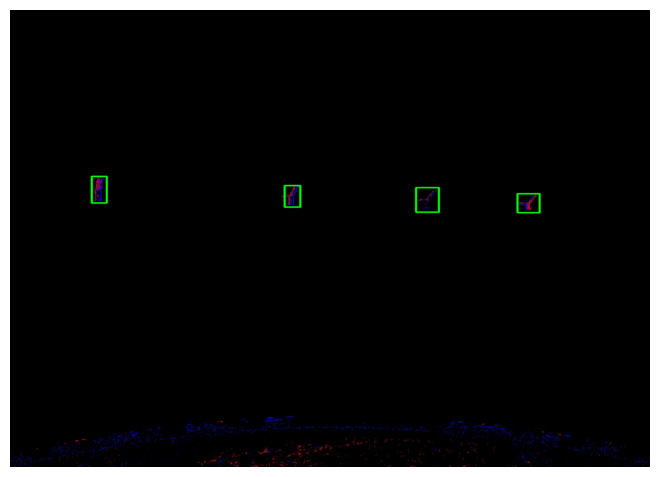

In [143]:
# Specify the output file path
output_file_path = "detection_coordinates.txt"

for index in range(len(test_images)):

    # index = random.randint(0, len(test_images) - 1)
    # index = 98
    # print("Image index:", index)

    sample_image_t = tf.constant(test_images[index], dtype=tf.uint8)
    sample_image_t = tf.expand_dims(sample_image_t, axis=0)
    image_np = sample_image_t.numpy()

    boxes, scores, classes, num_detections = effdet2_model(image_np)

    image_np = image_np[0]

    # print("Image shape:", image_np.shape)
    # print("Model Result Shapes:", boxes.shape, scores.shape, classes.shape, num_detections)
    # print()

    img, objects, box_list = get_annotated_img_objects(image_np, boxes[0], scores[0], num_detections[0])
    time_stamp = frame_index_to_time_stamp(index+1, fps)

    print("Time stamp :", round(time_stamp,2), "s","No. of objects:", objects)
    # print("No. of objects:", objects)
    print ("Detection Coordinates:", box_list)
    # print (box_list)

    # Write the list to the text file
    with open(output_file_path, "a") as output_file:
        # output_file.write(f"Image Index: {index}\n")
        # output_file.write(f"Time stamp: {time_stamp}")
        # output_file.write(f"No. of objects: {objects}\n")
        output_file.write("Time stamp: {}s No. of satellites: {}\n".format(round(time_stamp,2), objects))
        output_file.write(f"Detection Coordinates: {box_list}\n")


    # Reshape the image to the desired dimensions
    # Specify the new dimensions
    new_width = 1400
    new_height = 1000
    img = resize(img, (new_height, new_width))
    
    plt.imshow(img)
    plt.axis('off')
    plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
    # plt.show()
    

    # Create a directory to save the plots if it doesn't exist
    output_folder = "results/"
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    plt.savefig(output_folder + str(index) + '_effdet2_result.png')


# Create video from image detection results

In [144]:
# Create Video from results

!video-fromimg --input-files "results/*.png" --fps 30 Eventcamera_detection.mp4

{'fps': 30,
 'input_files': 'results/*.png',
 'nframes': None,
 'out_file': 'Eventcamera_detection.mp4'}
Eventcamera_detection.mp4: 100%|██████████████| 120/120 [00:02<00:00, 55.68it/s]
